In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import networkx as nx
import matplotlib.pyplot as plt

c:\Users\loren\anaconda3\envs\TensorFlow\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%run -i simulator.py

In [3]:
p = 3
q = 2
N = 20

simulator = GRDPG(p, q, N)

In [4]:
A = simulator.sample_Beta(1/2, 1)

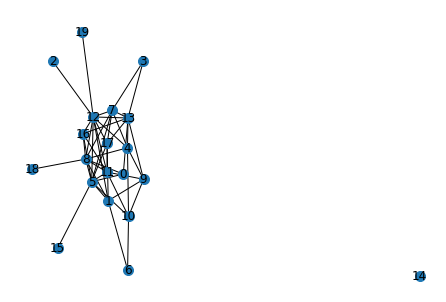

In [6]:
g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

# Example of simulation from the Block model

In [7]:
%run -i simulator.py

In [8]:
Ncommunities = 10

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))

# print(np.round(B.numpy(), 2))

In [9]:
N = 100
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

# print(E.numpy())

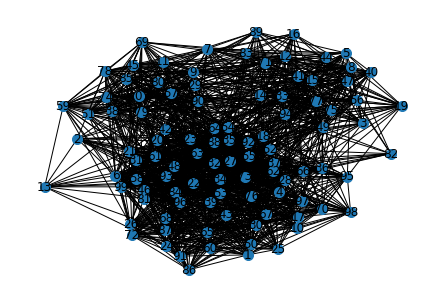

In [10]:
A = simulator.sample(E)

g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

In [11]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)
newsimulator = GRDPG(p, q, N)

Xminus = X*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

M    = tf.einsum("kj,nj->nk", tf.einsum("nk,kj->nj", E, B), E)
newM = tf.einsum("ik,jk->ij", Xminus, X)

newB = tf.linalg.matmul(tf.linalg.matmul(eigenvect_eigenval, tf.linalg.diag(newsimulator.I)), tf.transpose(eigenvect_eigenval))

print("there are "+str(q)+" negative eigenvalues.")
print("we recover B: "+str(tf.reduce_all(tf.abs(B-newB)<1e-5).numpy()))
print("we recover M: "+str(tf.reduce_all(tf.abs(M-newM)<1e-5).numpy()))

there are 2 negative eigenvalues.
we recover B: True
we recover M: True


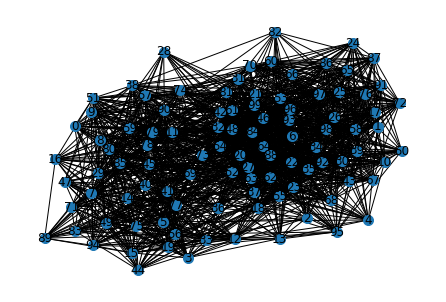

In [12]:
newsimulator = GRDPG(p, q, N)

A = newsimulator.sample(X)
g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=100, with_labels=True)

# Spectral embedding 

In [25]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.51593006, 0.04917296],
       [0.04917296, 0.51607454]], dtype=float32)>

In [28]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.38578881, 0.61421119])>

In [29]:
N = 2000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

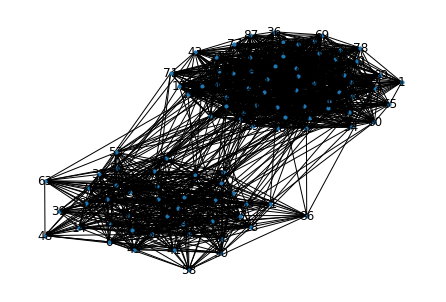

In [30]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [31]:
def d_spectral(A, d):

    eigenvalues, eigenvectors = tf.linalg.eig(A)

    eigenvalues  = tf.math.real(eigenvalues )
    eigenvectors = tf.math.real(eigenvectors)

    eigenvalues  = eigenvalues[-d:]
    eigenvectors = eigenvectors[:,-d:]

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", eigenvectors_sort, tf.sqrt(tf.abs(eigenvalues_sort)))

In [32]:
d = 2
p, q, hatX = d_spectral(A, d)

In [33]:
newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.116523564


# Spectral embedding- TensorLy

In [12]:
Ncommunities = 2

B = tfp.distributions.Beta(1/10, 1/2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.4496342 , 0.01878284],
       [0.01878284, 0.5000206 ]], dtype=float32)>

In [13]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.38706774, 0.61293226])>

In [14]:
N = 4000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

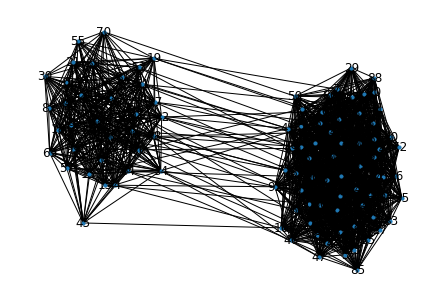

In [67]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [3]:
import tensorly

def d_spectral_tensorly(A, d):

    eigenvectors, eigenvalues, _ = tensorly.partial_svd(A.numpy(), n_eigenvecs=d)

    eigenvalues_sort    = tf.sort(   eigenvalues, direction='DESCENDING')
    eigenvalues_argsort = tf.argsort(eigenvalues, direction='DESCENDING')
    eigenvectors_sort   = tf.gather(eigenvectors, eigenvalues_argsort, axis = 1)

    q = sum(eigenvalues_sort.numpy()<0)
    p = eigenvalues_sort.shape[0] - q

    return p, q, tf.einsum("ni,i->ni", eigenvectors_sort, tf.sqrt(tf.abs(eigenvalues_sort)))

In [70]:
d = 2
p, q, hatX = d_spectral_tensorly(A, d)

newsimulator = GRDPG(p, q, N)

hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))

hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)
print("the max norm of the difference between M and hatM is "+str(tf.reduce_max(tf.abs(M-hatM)).numpy()))

the max norm of the difference between M and hatM is 0.14402455


# Weighted bootstrap

In [4]:
Ncommunities = 2

B = tfp.distributions.Beta(1/2, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.5*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.5909465 , 0.05635871],
       [0.05635871, 0.8624543 ]], dtype=float32)>

In [5]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.64433422, 0.35566578])>

In [6]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

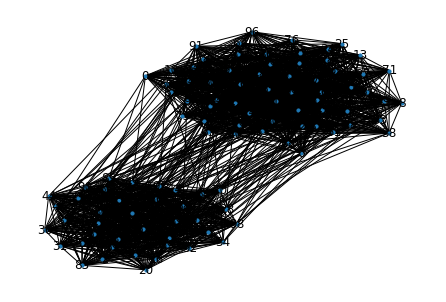

In [7]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [8]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [9]:
def weighted_bootstrap(iterations, A, d):

    p_list = []
    q_list = []
    hatX_list = []

    for i in range(iterations):

        W = tfp.distributions.Exponential(rate = 1).sample(A.shape)
        p, q, hatX = d_spectral_tensorly(W*A, d)

        p_list.append(p)
        q_list.append(q)
        hatX_list.append(hatX)

    return p_list, q_list, hatX_list



In [10]:
iterations = 100
d = 2

p_list, q_list, hatX_list = weighted_bootstrap(iterations, A, d)


In [11]:
i = 0

p, q, hatX = p_list[i], q_list[i], hatX_list[i]
newsimulator = GRDPG(p, q, N)
hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

for i in range(1, iterations):

    p, q, hatX = p_list[i], q_list[i], hatX_list[i]
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

    hatMsample = tf.concat((hatMsample, hatM), axis = 2)


In [12]:
M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

In [13]:
quantileshatM = np.quantile(hatMsample.numpy(), q = (0.025, 0.975), axis = 2)

In [14]:
print("the empirical coverage of the 0.95 credible interval is "+str((tf.reduce_sum(tf.cast(M>quantileshatM[0,:,:], dtype = tf.float32)*tf.cast(M<quantileshatM[1,:,:], dtype = tf.float32))/(M.shape[0]*M.shape[1])).numpy()))

the empirical coverage of the 0.95 credible interval is 0.968262


In [15]:
individual_0 = [hatX_list[i][0,:].numpy() for i in range(iterations)]

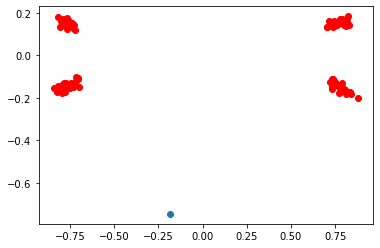

In [16]:
for i in range(iterations):

    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

plt.scatter(X[0,0], X[0,1])

# DropConnect bootstrap

In [97]:
Ncommunities = 2

B = tfp.distributions.Beta(1/3, 2).sample((Ncommunities,Ncommunities))
B = tf.experimental.numpy.triu(B + 0.1*tf.eye(Ncommunities))
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))
B

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.2777591 , 0.00055017],
       [0.00055017, 0.1927552 ]], dtype=float32)>

In [98]:
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(5, 0.1, Ncommunities))).sample()
initial_distribution

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.70436099, 0.29563901])>

In [99]:
N = 1000

simulator = stochasticBlockModel(B)
E         = simulator.pop_sample(initial_distribution, N)

A = simulator.sample(E)

# g = nx.from_numpy_matrix(A.numpy(), create_using=nx.DiGraph).to_undirected()
# nx.draw(g, node_size=10, with_labels=True)

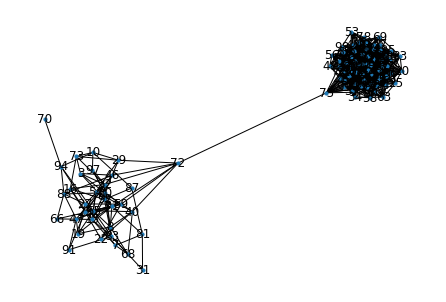

In [100]:
g = nx.from_numpy_matrix(A[:100,:100].numpy(), create_using=nx.DiGraph).to_undirected()
nx.draw(g, node_size=10, with_labels=True)

In [106]:
p, q, eigenvect_eigenval, X = simulator.to_GRDPG(E)

In [127]:
def dropconnect_bootstrap(iterations, p, A, d):

    p_list = []
    q_list = []
    hatX_list = []

    # A_neigh = tf.cast(tf.einsum("ik,kj->ij", A, A)>1, dtype = tf.float32)
    p, q, hatX = d_spectral_tensorly(A, d)
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    for i in range(iterations):
        
        Xi = tf.cast(tfp.distributions.Bernoulli(probs = hatM).sample(),     dtype = tf.float32)
        M  = tf.cast(tfp.distributions.Bernoulli(probs = p).sample(A.shape), dtype = tf.float32)

        p, q, hatX = d_spectral_tensorly(M*Xi + (1-M)*A, d)

        p_list.append(p)
        q_list.append(q)
        hatX_list.append(hatX)

    return p_list, q_list, hatX_list



In [142]:
iterations = 100
d = 2

p     = 1

p_list, q_list, hatX_list = dropconnect_bootstrap(iterations, p, A, d)


In [143]:
i = 0

p, q, hatX = p_list[i], q_list[i], hatX_list[i]
newsimulator = GRDPG(p, q, N)
hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

hatMsample = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

for i in range(1, iterations):

    p, q, hatX = p_list[i], q_list[i], hatX_list[i]
    newsimulator = GRDPG(p, q, N)
    hatXminus = hatX*tf.reshape(newsimulator.I, (1, newsimulator.p+newsimulator.q))
    hatM = tf.einsum("ik,jk->ij", hatXminus, hatX)

    hatM = tf.reshape(hatM, (hatM.shape[0], hatM.shape[1], 1))

    hatMsample = tf.concat((hatMsample, hatM), axis = 2)


In [144]:
M = tf.einsum("nj,kj->nk", tf.einsum("nk,kj->nj", E, B), E)

In [145]:
quantileshatM = np.quantile(hatMsample.numpy(), q = (0.025, 0.975), axis = 2)

In [146]:
print("the empirical coverage of the 0.95 credible interval is "+str((tf.reduce_sum(tf.cast(M>quantileshatM[0,:,:], dtype = tf.float32)*tf.cast(M<quantileshatM[1,:,:], dtype = tf.float32))/(M.shape[0]*M.shape[1])).numpy()))

the empirical coverage of the 0.95 credible interval is 0.960929


In [147]:
individual_0 = [hatX_list[i][0,:].numpy() for i in range(iterations)]

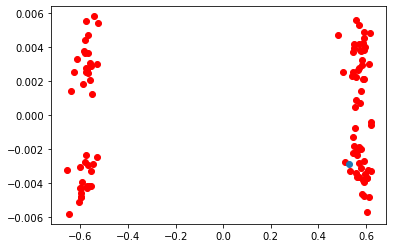

In [148]:
for i in range(iterations):

    plt.scatter(individual_0[i][0], individual_0[i][1], color = "red")

plt.scatter(X[0,0], X[0,1])